In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras import utils
from imgaug import augmenters as iaa

# 進度條模組
from tqdm import tqdm
%matplotlib inline

In [2]:
#檢測tensorflow gpu是否啟用
tf.config.list_physical_devices("GPU")
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'#选择哪一块gpu
config = ConfigProto()
# config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
# config.gpu_options.per_process_gpu_memory_fraction=0.5 #分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
config.gpu_options.allow_growth = True #按

# Data processing

In [4]:
# 5種類
# class_names = ['normal'  , 'error_iron' , 'error_ear' , 'noiron' , 'noearing']

# 7種類
class_names = ['normal' , 'error_ear' , 'error_iron' , 'error_solder' , 'noearing' , 'noiron' , 'NG']

class_names_label = {class_name:i for i,class_name in enumerate(class_names)}
print(class_names_label)

num_class = len(class_names)

IMAGE_SIZE = (240 , 130)

{'normal': 0, 'error_ear': 1, 'error_iron': 2, 'error_solder': 3, 'noearing': 4, 'noiron': 5, 'NG': 6}


In [5]:
def load_data():
#     5 label
#     datasets = ['E:/mask_data/New_mask_data_5/train' , 'E:/mask_data/New_mask_data_5/validation' , 'E:/mask_data/New_mask_data_5/test']

#     8 label
    datasets = ['E:/mask_data/New_mask_data/train' , 'E:/mask_data/New_mask_data/validation' , 'E:/mask_data/New_mask_data/test']
    output = []
    
    for dataset in datasets:
        images = []
        labels = []
        
        print('Loading{}'.format(dataset))
        if dataset == datasets[0]:
            for folder in os.listdir(dataset):
                label = class_names_label[folder]

                for file in (os.listdir(os.path.join(dataset , folder))):


                    img_path = os.path.join(os.path.join(dataset , folder), file)

                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
                    image = cv2.resize(image , IMAGE_SIZE)
                    images.append(image)
                    labels.append(label)

                    flipper = iaa.Fliplr(1.0) #水平翻轉機率==1.0
                    image_f = flipper.augment_image(image) 
                    images.append(image_f)
                    labels.append(label)

                    vflipper = iaa.Flipud(1.0) #垂直翻轉機率40%
                    image_v = vflipper.augment_image(image) 
                    images.append(image_v)
                    labels.append(label)

            images = np.array(images , dtype = 'float32')
            labels = np.array(labels , dtype = 'int32')
            labels = utils.to_categorical(labels , num_class , dtype = 'int32')
            output.append((images,labels))
        else:
            for folder in os.listdir(dataset):
                label = class_names_label[folder]

                for file in (os.listdir(os.path.join(dataset , folder))):


                    img_path = os.path.join(os.path.join(dataset , folder), file)

                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
                    image = cv2.resize(image , IMAGE_SIZE)
                    images.append(image)
                    labels.append(label)

            images = np.array(images , dtype = 'float32')
            labels = np.array(labels , dtype = 'int32')
            labels = utils.to_categorical(labels , num_class , dtype = 'int32')
            output.append((images,labels))
        
    return output 

In [6]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

LoadingE:/mask_data/New_mask_data/train
LoadingE:/mask_data/New_mask_data/validation
LoadingE:/mask_data/New_mask_data/test


In [7]:
from sklearn.utils import shuffle           

train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
val_images, val_labels = shuffle(val_images, val_labels, random_state=25)
test_images, test_labels = shuffle(test_images, test_labels, random_state = 25)

In [8]:
# check how many training and testing example do we have
# check the size of image

n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print('Number of training example : {}'.format(n_train))
print('Number of training example : {}'.format(n_val))
print('Number of testing example : {}'.format(n_test))
print('Each image is of size : {}'.format(IMAGE_SIZE))

Number of training example : 4290
Number of training example : 409
Number of testing example : 208
Each image is of size : (240, 130)


In [9]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

In [10]:
# 灰階專用
train_images = tf.expand_dims(train_images, axis=-1)
val_images = tf.expand_dims(val_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

BATCH_SIZE = 8

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

print(train_dataset)
print(val_dataset)

<BatchDataset shapes: ((None, 130, 240, 1), (None, 7)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 130, 240, 1), (None, 7)), types: (tf.float32, tf.int32)>


# Create Model

In [12]:
import Evolved_Model as EV_Model
import Reorganized_Block_6 as RE_Block_6
import Reorganized_Block_5 as RE_Block_5

from tensorflow.keras.layers import Input

input_layer = Input(shape=(130,240,1) , name='input_layer')

# Reorganized_model = RE_Block_5.Evolved_51(input_layer)
Reorganized_model = RE_Block_5.Evolved_52(input_layer)
# Reorganized_model = RE_Block_5.Evolved_53(input_layer)
# Reorganized_model = RE_Block_5.Evolved_54(input_layer)
# Reorganized_model = RE_Block_5.Evolved_55(input_layer)
# Reorganized_model = RE_Block_5.Evolved_56(input_layer)
# Reorganized_model = RE_Block_5.Evolved_57(input_layer)

# Reorganized_model = RE_Block_6.Evolved_61(input_layer)
# Reorganized_model = RE_Block_6.Evolved_62(input_layer)
# Reorganized_model = RE_Block_6.Evolved_63(input_layer)
# Reorganized_model = RE_Block_6.Evolved_64(input_layer)
# Reorganized_model = RE_Block_6.Evolved_65(input_layer)
# Reorganized_model = RE_Block_6.Evolved_66(input_layer)
# Reorganized_model = RE_Block_6.Evolved_67(input_layer)


Reorganized_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 130, 240, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 130, 240, 1)  0           input_layer[0][0]                
__________________________________________________________________________________________________
normalization (Normalization)   (None, 130, 240, 1)  3           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 132, 242, 1)  0           normalization[0][0]              
___________________________________________________________________________________________

In [13]:
from tensorflow.keras.layers import Conv2D , GlobalAveragePooling2D , MaxPool2D , Dense ,Dropout

output = Reorganized_model.output
top_se_squeeze = GlobalAveragePooling2D(name='top_se_squeeze')(output)
top_dopout = Dropout(0.2)(top_se_squeeze)
top_dense = Dense(num_class, activation='softmax', name='softmax')(top_dopout)

In [14]:
from tensorflow.keras.models import Model

name='Reorganized_7Label_R52'

Reorganized_model = Model(input_layer , top_dense ,name=name)
# Reorganized_model = Model(input_layer , top_dense ,name=name)


Reorganized_model.summary()

Model: "Reorganized_7Label_R52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 130, 240, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 130, 240, 1)  0           input_layer[0][0]                
__________________________________________________________________________________________________
normalization (Normalization)   (None, 130, 240, 1)  3           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 132, 242, 1)  0           normalization[0][0]              
_____________________________________________________________________________

# Data Training

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

start = time.perf_counter()

Adam = tf.keras.optimizers.Adam(learning_rate=0.00025,name='Adam')

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)

filepath = 'Mask-Reorganized_7Label_R52.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, verbose=1, mode='max', min_lr=0.0001)

# callback_list = [checkpoint , reduce_lr , earlystop]
callback_list = [checkpoint , reduce_lr]



Reorganized_model.compile(loss='categorical_crossentropy',optimizer=Adam,metrics=['accuracy'])

history = Reorganized_model.fit(train_dataset, epochs=25, verbose=1, validation_data = val_dataset,callbacks = callback_list)

Epoch 1/25
537/537 [==============================] - 176s 305ms/step - loss: 1.7575 - accuracy: 0.2836 - val_loss: 1.6637 - val_accuracy: 0.5086

Epoch 00001: val_accuracy improved from -inf to 0.50856, saving model to Mask-Reorganized_7Label_R52.h5
Epoch 2/25
537/537 [==============================] - 154s 288ms/step - loss: 0.8435 - accuracy: 0.6433 - val_loss: 1.0603 - val_accuracy: 0.6259

Epoch 00002: val_accuracy improved from 0.50856 to 0.62592, saving model to Mask-Reorganized_7Label_R52.h5
Epoch 3/25
537/537 [==============================] - 165s 306ms/step - loss: 0.5141 - accuracy: 0.8025 - val_loss: 0.7340 - val_accuracy: 0.7139

Epoch 00003: val_accuracy improved from 0.62592 to 0.71394, saving model to Mask-Reorganized_7Label_R52.h5
Epoch 4/25
537/537 [==============================] - 154s 286ms/step - loss: 0.3957 - accuracy: 0.8553 - val_loss: 0.9705 - val_accuracy: 0.6699

Epoch 00004: val_accuracy did not improve from 0.71394

Epoch 00004: ReduceLROnPlateau reducin

In [16]:
import math

end = time.perf_counter()

print('Time：'+str(math.floor(end - start)))

Time：3815


In [17]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'b-', label = "acc")
    plt.plot(history.history['val_accuracy'], 'r-', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'b-', label = "loss")
    plt.plot(history.history['val_loss'], 'r-', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

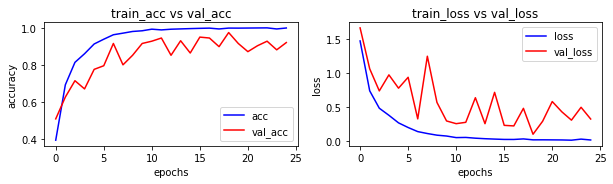

In [18]:
plot_accuracy_loss(history)

# Prediction

In [19]:
model = tf.keras.models.load_model(filepath)

predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 
pred_labels = np.array(pred_labels,dtype = 'int32')
pred_labels

array([0, 0, 0, 4, 1, 0, 0, 6, 0, 6, 4, 0, 2, 1, 2, 0, 6, 2, 1, 3, 3, 6,
       4, 0, 1, 1, 4, 0, 4, 1, 0, 0, 1, 3, 2, 1, 1, 2, 6, 2, 6, 0, 0, 3,
       4, 1, 2, 1, 0, 6, 1, 0, 1, 4, 6, 1, 3, 1, 1, 6, 3, 5, 2, 0, 0, 2,
       1, 4, 0, 5, 1, 0, 6, 6, 2, 1, 0, 6, 0, 4, 4, 2, 0, 6, 3, 0, 2, 4,
       6, 6, 1, 0, 0, 6, 0, 0, 2, 4, 3, 4, 1, 2, 1, 5, 6, 3, 4, 6, 1, 1,
       2, 0, 0, 2, 2, 1, 4, 4, 1, 0, 1, 3, 5, 1, 1, 6, 1, 3, 1, 6, 0, 6,
       3, 1, 4, 2, 5, 2, 0, 2, 2, 1, 6, 0, 1, 3, 5, 1, 2, 5, 2, 0, 0, 1,
       4, 0, 3, 1, 1, 1, 2, 1, 4, 6, 6, 5, 6, 0, 6, 4, 0, 6, 0, 2, 4, 0,
       4, 1, 2, 6, 4, 2, 2, 0, 5, 2, 4, 2, 3, 0, 0, 3, 1, 0, 4, 5, 3, 0,
       5, 4, 0, 0, 5, 6, 2, 4, 2, 4])

In [20]:
labels = np.argmax(test_labels, axis = 1) 
labels

array([0, 0, 0, 4, 1, 0, 0, 6, 0, 6, 4, 0, 2, 1, 2, 0, 6, 2, 1, 3, 3, 6,
       4, 0, 1, 1, 4, 0, 4, 1, 0, 0, 1, 3, 2, 1, 1, 2, 6, 2, 6, 0, 0, 3,
       4, 1, 2, 1, 0, 6, 1, 0, 1, 4, 6, 1, 3, 1, 1, 6, 3, 5, 2, 0, 0, 2,
       1, 4, 0, 5, 1, 0, 6, 6, 2, 1, 0, 6, 0, 4, 4, 2, 0, 6, 6, 0, 2, 4,
       6, 6, 1, 0, 0, 6, 0, 0, 2, 4, 3, 4, 1, 2, 1, 5, 6, 3, 1, 6, 1, 1,
       2, 0, 0, 2, 2, 1, 4, 4, 1, 0, 1, 3, 5, 1, 1, 6, 1, 3, 1, 6, 0, 6,
       3, 1, 4, 2, 5, 2, 0, 2, 2, 1, 6, 0, 1, 3, 5, 1, 2, 5, 2, 0, 0, 1,
       4, 0, 3, 1, 1, 1, 2, 1, 4, 6, 6, 5, 6, 0, 6, 4, 0, 6, 0, 2, 4, 0,
       4, 1, 2, 6, 4, 2, 2, 0, 5, 1, 4, 2, 3, 0, 0, 3, 1, 0, 4, 5, 3, 0,
       5, 4, 0, 0, 5, 6, 2, 4, 2, 4], dtype=int64)

In [21]:
results = model.evaluate(test_images, test_labels, batch_size=128)
print("test loss, test acc:", results)

2/2 [==============================] - 6s 2s/step - loss: 0.1011 - accuracy: 0.9856
test loss, test acc: [0.10108572989702225, 0.9855769276618958]


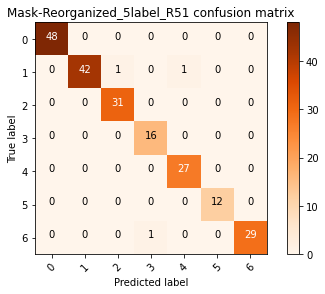

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Mask-Reorganized_5label_R51 confusion matrix'

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('E://Mask_confusion//Mask-EvolvedB7.jpg')
    plt.show()


confusion_mtx = confusion_matrix(labels, pred_labels)
plot_confusion_matrix(confusion_mtx, classes = range(num_class))

In [23]:
count = 0
fail = 0

for i in range(208):
    count+=1
    if pred_labels[i]!=labels[i]:
        fail+=1
print(count)
print(fail)

208
3
